In [1]:
import math
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
# ------------------------------------
# return 3D coordinates for board corners of given size
def get3DCoor(sizeBoardCorners):
    r, c = sizeBoardCorners
    tar = np.zeros((r*c, 3), np.float32)
    tar[:,:2] = np.mgrid[0:r, 0:c].T.reshape(-1, 2)
    return tar

# ------------------------------------
# find corners of all images from a directory with given corner shape, then caliculate matrix for correcting distortion
def calDistortMatrix(fileDir, sizeBoardCorners):
    calFiles = glob.glob("camera_cal/calibration*.jpg")

    corners_img = []
    corners_tar = []
    
    tarCoord = get3DCoor(sizeBoardCorners)
        
    i = 0
    for fname in calFiles:            
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
        if not ret: 
            print('failled finding board from: ', fname)
            continue
        
        corners_img.append(corners)
        corners_tar.append(tarCoord)
            
        # draw the board and the found corners to make sure all are found correctly
        cv2.drawChessboardCorners(gray, sizeBoardCorners, corners, ret)
        plt.subplot(5, 5, i+1)
        plt.imshow(gray)
        i += 1
    plt.show()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(corners_tar, corners_img, gray.shape, None, None)
    return ret, mtx, dist

Run estimation of distoration over all chessboard images that have 9-by-6 corners within.

failled finding board from:  camera_cal/calibration5.jpg
failled finding board from:  camera_cal/calibration4.jpg
failled finding board from:  camera_cal/calibration1.jpg


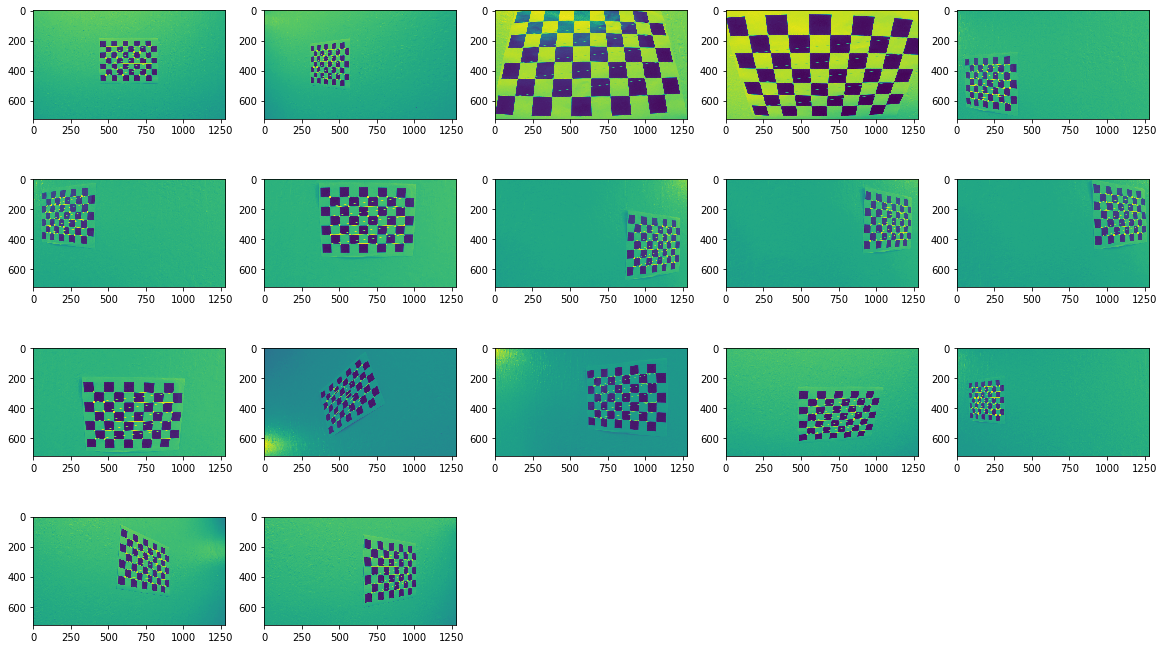

In [3]:
# ------------------------------------
plt.rcParams['figure.figsize'] = (20, 15)

sizeBoardCorners = (9, 6)
ret, mtx, dist = calDistortMatrix('camera_cal', sizeBoardCorners)

### Apply the distortion correction to one of the calibration image:

Text(0.5,1,'Undistorted Image')

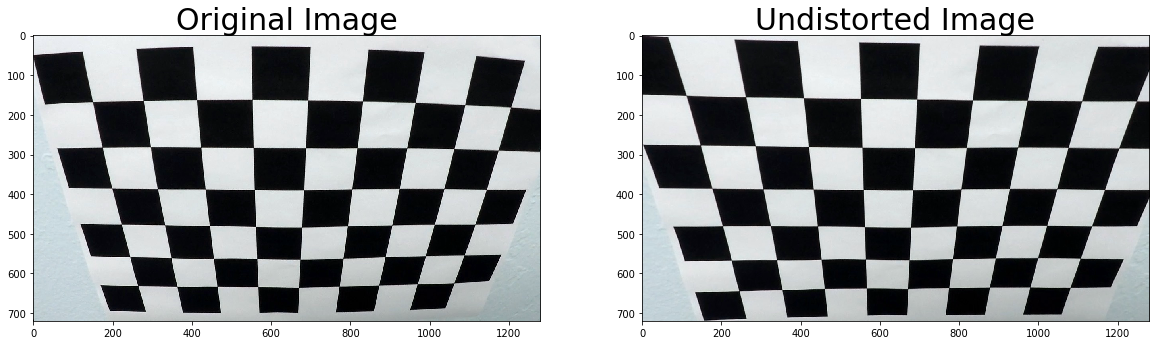

In [4]:
fn = 'camera_cal/calibration2.jpg'
img = cv2.imread(fn)
img_corrected = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_corrected)
ax2.set_title('Undistorted Image', fontsize=30)

### Use color transforms, gradients, etc., to create a thresholded binary image
Define all kinds of masking functions first.

In [5]:
# ------------------------------------
def getGrad(img, kernelSize):    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
    gradx = cv2.Sobel(img_gray, ddepth=cv2.CV_64F, dx=1, dy=0, ksize = kernelSize)
    grady = cv2.Sobel(img_gray, ddepth=cv2.CV_64F, dx=0, dy=1, ksize = kernelSize)    
    return gradx, grady


# ------------------------------------
# masking based on direction of the gradient
# img BGR color image, default threshhold: 0~pi/2
def gradientDirectionMask(gradx, grady, thresh=[0, np.pi/2]):
    angle = np.arctan2(np.absolute(grady), np.absolute(gradx))
    angle = np.absolute(angle)
    
    binary_output = np.zeros_like(angle)
    binary_output[(angle >= thresh[0]) & (angle < thresh[1])] = 1    
    return binary_output


# ------------------------------------
# masking based on magnitude of the gradient, threshhold
# img BGR color image, default threshhold:0~255
def gradientMagnitudeMask(gradx, grady, thresh=[0, 255], axis='x'):
    if axis == 'x':
        gradm = np.absolute(gradx)
    else:
        gradm = np.absolute(grady)
    gradm = gradm/gradm.max()*255
    
    binary_output = np.zeros_like(gradm)
    binary_output[(gradm >= thresh[0]) & (gradm < thresh[1])] = 1    
    return binary_output
    
    
# ------------------------------------
# masking based on the selected channel of the HLS representation of the image
# img BGR color image, default threshhold: 0~255
def colorChannelMask(img, thresh=[0, 255], channel='S'):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    channelMap = {'H':0, 'L':1, 'S':2}
    ch = channelMap[channel]
    singleChannel = hls[:, :, ch]
    
    binary_output = np.zeros_like(singleChannel)
    binary_output[(singleChannel >= thresh[0]) & (singleChannel <= thresh[1])] = 1
    return binary_output

def regionOfInterestMask(img):
    sizy, sizx, dummy = img.shape
    roi = np.array([[sizx*0.4, sizy*0.45], [sizx*0.05, sizy*0.95], [sizx*0.95, sizy*0.95], [sizx*0.6, sizy*0.45]]).astype(int)
    
    binary_mask = np.zeros((sizy, sizx))
    cv2.fillPoly(binary_mask, [roi], 1)
    return binary_mask

    
# ------------------------------------
# Input BGR color image
# Ouput Binary map 
# This function controls all threshholds for each individual type of masking
def findAllMasks(img):
    # Yellow channel
    rg_mask = (img[:,:,1] > 150) & (img[:,:,2] > 150)
    
    # Gradient related
    gradx, grady = getGrad(img, kernelSize = 3)    
    dir_mask = gradientDirectionMask(gradx, grady, thresh=(np.pi/6, np.pi/2))
    mag_mask = gradientMagnitudeMask(gradx, grady, thresh=(10, 200),  axis='x')
    gradient_mask = cv2.bitwise_and(dir_mask, mag_mask)
    
    # S channel
    s_mask = colorChannelMask(img, thresh=[100, 255], channel='S')
    
    # Region of Interest
    roi_mask = regionOfInterestMask(img)
    
    allMasks = {
        'rg': rg_mask, 
        'grad':gradient_mask,
        's': s_mask,
        'roi': roi_mask,
    }
    
    return allMasks


# ------------------------------------
# Stack 3 2D images/masks into RGB color images for viewing
def mergeMasks2RGB(masks):
    return np.stack(masks, axis=2)*255


# ------------------------------------
# Combine all individual masks 
def combineMasks(img):
    allMasks = findAllMasks(img)
    
    rg_mask = allMasks['rg']
    gradient_mask = allMasks['grad']
    s_mask = allMasks['s']
    roi_mask = allMasks['roi']

    # keep strong yellow channel and strong gradient
    combinedMask = (rg_mask > 0) & (gradient_mask > 0)
    
    # add the s-channel
    combinedMask = (combinedMask > 0) | (s_mask > 0)
    
    # cut off outer region and only keep region of interest in the lower middle part of the view
    combinedMask = (combinedMask > 0) & (roi_mask > 0)
    
    return combinedMask

Test the masking over testing images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


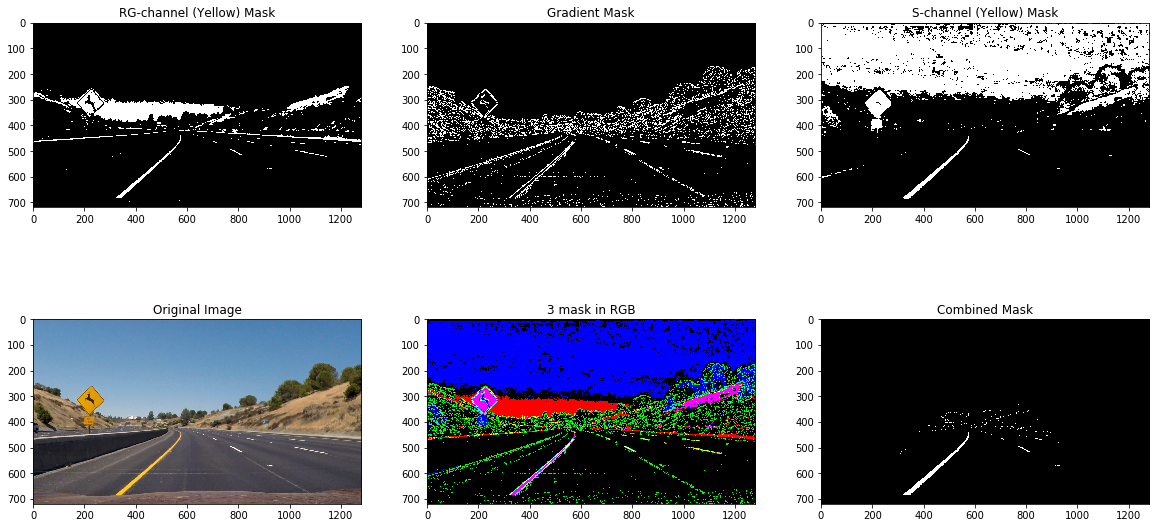

In [53]:
# ------------------------------------
plt.rcParams['figure.figsize'] = (20, 10)
testFn = 'test_images/test2.jpg'
imgTest = cv2.imread(testFn)

# get all individual masks for check
am = findAllMasks(imgTest)

rg_mask = am['rg']
gradient_mask = am['grad']
s_mask = am['s']
roi_mask = am['roi']

# the final combined mask
combinedMask = combineMasks(imgTest)

# Display
f, axhandles = plt.subplots(2, 3, figsize=(20,10))

axhandles[0, 0].imshow(rg_mask*255, cmap='gray')
axhandles[0, 0].set_title('RG-channel (Yellow) Mask')
axhandles[0, 1].imshow(gradient_mask*255, cmap='gray')
axhandles[0, 1].set_title('Gradient Mask')
axhandles[0, 2].imshow(s_mask*255, cmap='gray')
axhandles[0, 2].set_title('S-channel (Yellow) Mask')
    
axhandles[1, 0].imshow(cv2.cvtColor(imgTest, cv2.COLOR_BGR2RGB))
axhandles[1, 0].set_title('Original Image')
axhandles[1, 1].imshow(mergeMasks2RGB([rg_mask, gradient_mask, s_mask]))
axhandles[1, 1].set_title('3 mask in RGB')
axhandles[1, 2].imshow(combinedMask, cmap='gray')
axhandles[1, 2].set_title('Combined Mask')

plt.show()

### Apply a perspective transform to rectify binary image ("birds-eye view").

Text(0.5,1,' Bird-view Combined Mask')

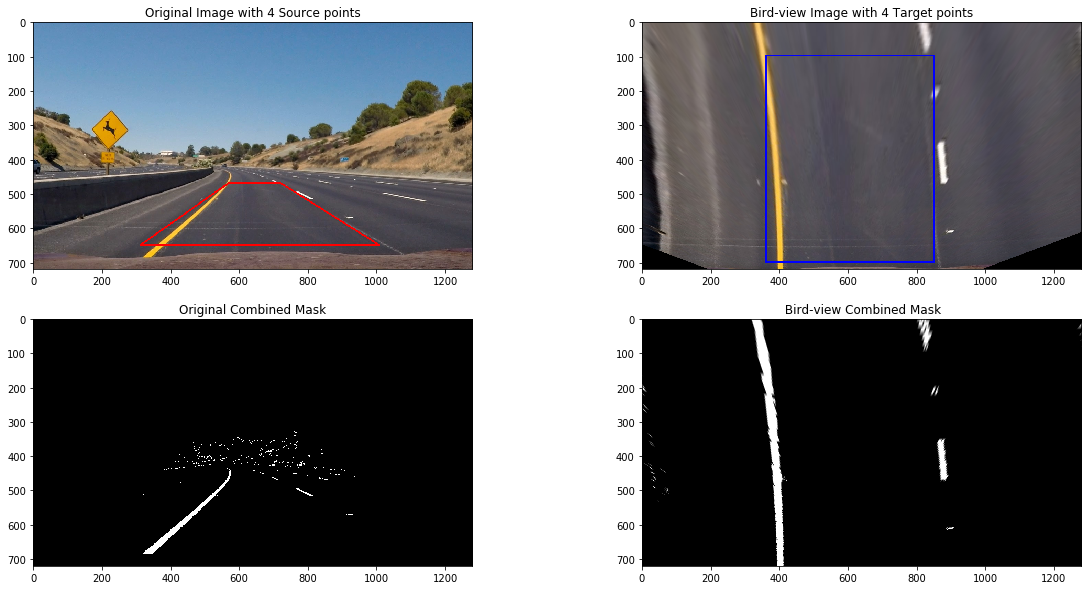

In [54]:
# define 4 points over a rectangular region within the lane in both the original view and the target (bird) view
points_orig = np.array([[312,650], [1007, 650], [720, 470], [568, 470]])
points_targ = np.array([[360,700], [850, 700], [850, 100], [360, 100]])

# make a copy of image for drawing
img_orig = np.copy(imgTest)
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

# Compute the forward and reverse persepective transform matrices
M         = cv2.getPerspectiveTransform(np.float32(points_orig), np.float32(points_targ))
M_inv = cv2.getPerspectiveTransform(np.float32(points_targ), np.float32(points_orig))
sizImg = (img_orig.shape[1], img_orig.shape[0])

# Apply the forward transform to get bird view image
img_bird = cv2.warpPerspective(img_orig, M, sizImg , flags=cv2.INTER_LINEAR)

# Draw boundaries of the rectangular in both views
cv2.polylines(img_orig, np.int32([points_orig]), isClosed=True, color=[255,0,0], thickness=3)
cv2.polylines(img_bird, np.int32([points_targ]), isClosed=True, color=[0,0,255], thickness=3)

# get mask and the bird-view of it
mask = combinedMask
mask_bird = cv2.warpPerspective(np.float64(mask), M, sizImg, flags=cv2.INTER_LINEAR)

# Display
f, axhandles = plt.subplots(2,2, figsize=(20,10))

axhandles[0,0].imshow(img_orig)
axhandles[0,0].set_title('Original Image with 4 Source points')

axhandles[0,1].imshow(img_bird)
axhandles[0,1].set_title('Bird-view Image with 4 Target points')

axhandles[1,0].imshow(mask, cmap = 'gray')
axhandles[1,0].set_title('Original Combined Mask')

axhandles[1,1].imshow(mask_bird, cmap = 'gray')
axhandles[1,1].set_title(' Bird-view Combined Mask')

### Detect lane pixels and fit to find the lane boundary.

In [99]:
class LaneFinder:
    '''
    Initialize the window size and allocate size for window coordinates etc
    '''
    def __init__(self, num_window=10, width_window = 200):
        self.isInit = False
        self.threshold_minCountToUpdateCenter = 90
        
        self.num_win = num_window
        self.WW = int(width_window/2)
        self.HW = 0
        
        self.x_center_llane = -1*np.ones((num_window, 1))
        self.x_center_rlane = -1*np.ones((num_window, 1))
        
        self.y_range = np.zeros((num_window, 2), np.int32)
        

    ''' 
    Run for the first time, check the center of each left and right lane and assign it to the first (lowest) window
    Initialize window height according to image height
    '''
    def init(self, img):
        self.sizy, self.sizx = img.shape
        self.HW = math.floor(self.sizy/self.num_win) # height of window
        
        for step in range(self.num_win):
            self.y_range[step] = [self.sizy - (step+1)*self.HW, self.sizy - (step)*self.HW]
        
        self.init_proj = np.sum(img[:int(self.sizy/2), :], axis=0) # project the image into x-axis
        self.x_center_llane[0] = np.argmax(self.init_proj[:int(self.sizx/2)])
        self.x_center_rlane[0] = np.argmax(self.init_proj[int(self.sizx/2):]) + int(self.sizx/2)
        print('Initial Lane Centers: left = {}, right = {}'.format(int(self.x_center_llane[0]),  int(self.x_center_rlane[0])))

        self.isInit = True

    '''
    '''
    def fitWindowCenter(self, img):        
        # new 3-channel mask for drawing
        self.out_img = np.dstack((img, img, img))*255
        
        # current non-zero coordinates
        self.nonzero_x = np.where(img>0)[1]
        self.nonzero_y = np.where(img>0)[0] 

        allPointsIndex_l = []
        allPointsIndex_r = []
        
        for step in range(self.num_win):
            # If the center of the window is -1, use previous window center
            if self.x_center_llane[step] == -1:
                self.x_center_llane[step] = self.x_center_llane[step-1]                
            if self.x_center_rlane[step] == -1:
                self.x_center_rlane[step] = self.x_center_rlane[step-1]
            
            # Set window ranges
            center_l = self.x_center_llane[step]
            center_r = self.x_center_rlane[step]
            xwin_l = [center_l-self.WW, center_l+self.WW]
            xwin_r = [center_r-self.WW, center_r+self.WW]
            ywin = self.y_range[step]
            
            # Find points within current window
            pointsIndex_l = self.findPointsIndex(xwin_l, ywin)
            pointsIndex_r = self.findPointsIndex(xwin_r, ywin)            
            allPointsIndex_l.append(pointsIndex_l)
            allPointsIndex_r.append(pointsIndex_r)
            
            # Update window center
            if pointsIndex_l.shape[0] > self.threshold_minCountToUpdateCenter:
                self.x_center_llane[step] = np.mean(self.nonzero_x[pointsIndex_l][0])
                center_l = self.x_center_llane[step]
                xwin_l = [center_l-self.WW, center_l+self.WW]
            
            if pointsIndex_r.shape[0] > self.threshold_minCountToUpdateCenter:
                self.x_center_rlane[step] = np.mean(self.nonzero_x[pointsIndex_r][0])
                center_r = self.x_center_rlane[step]
                xwin_r = [center_r-self.WW, center_r+self.WW]
                
            print('window # {} centers: l {}, r {}'.format(step, self.x_center_llane[step], self.x_center_rlane[step]))
            
            cv2.rectangle(self.out_img, (xwin_l[0], ywin[0]), (xwin_l[1], ywin[1]),\
                          color=(255,0,0), thickness=2)
            cv2.rectangle(self.out_img, (xwin_r[0], ywin[0]), (xwin_r[1], ywin[1]),\
                          color=(0,0,255), thickness=2)
            
        # Fit a second order polynomial to each
        allPointsIndex_l = np.concatenate(allPointsIndex_l)
        allPointsIndex_r = np.concatenate(allPointsIndex_r)
        allPointsIndex_l = np.squeeze(allPointsIndex_l)
        allPointsIndex_r = np.squeeze(allPointsIndex_r)

        self.fit_l = np.polyfit(self.nonzero_y[allPointsIndex_l], self.nonzero_x[allPointsIndex_l], 2)
        self.fit_r = np.polyfit(self.nonzero_y[allPointsIndex_r], self.nonzero_x[allPointsIndex_r], 2)
        print(self.fit_l, self.fit_r)
    
    def findPointsIndex(self, xrange, yrange):
        pntIndex = np.where((self.nonzero_x > xrange[0]) & (self.nonzero_x < xrange[1]) & (self.nonzero_y > yrange[0]) & (self.nonzero_y < yrange[1]))
        return np.squeeze(np.array(pntIndex))
        
    # INPUT: 
    # img should be 2D grayscale, bird-view image of lanes from combined mask
    # num_window and width_window define the sliding window
    def run(self, mask):
        # Initialize 
        if not self.isInit:
            self.init(mask)
            
        # Find window centers
        self.fitWindowCenter(mask)
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Initial Lane Centers: left = 369, right = 828
window # 0 centers: l [390.], r [828.]
window # 1 centers: l [387.], r [888.]
window # 2 centers: l [382.], r [888.]
window # 3 centers: l [375.], r [862.]
window # 4 centers: l [371.], r [858.]
window # 5 centers: l [361.], r [865.]
window # 6 centers: l [352.], r [841.]
window # 7 centers: l [347.], r [850.]
window # 8 centers: l [329.], r [816.]
window # 9 centers: l [316.], r [800.]
<class 'list'>
[-1.35355198e-04  1.90481294e-01  3.33691777e+02] [-7.42366156e-05  1.69824468e-01  8.16520023e+02]
(1280,)


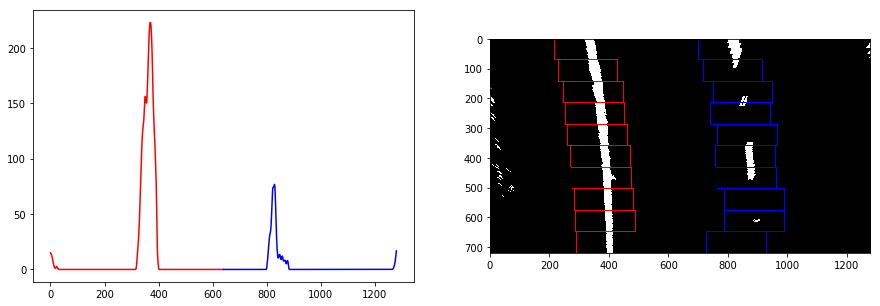

In [100]:
plt.rcParams['figure.figsize'] = (15, 5)

m = np.copy(mask_bird)
laneFinderObj = LaneFinder()
laneFinderObj.run(m)

proj = laneFinderObj.init_proj
halfLen = int(len(proj)/2)
rng1 = range(halfLen)
rng2 = range(halfLen, 2*halfLen)

print(proj.shape)
plt.subplot(1,2,1)
plt.plot(rng1, proj[rng1], 'r', rng2, proj[rng2], 'b')

plt.subplot(1,2,2)
plt.imshow(laneFinderObj.out_img)
plt.show()

### Determine the curvature of the lane and vehicle position with respect to center.

In [ ]:
print(np.where(mask_bird>0))

### Warp the detected lane boundaries back onto the original image.

In [36]:
x = np.array([-1, -1, -1, 1,2,3,4,5,6,7,8,9,10])
y = np.where((x > 5) & (x < 9))
print(y)

(array([ 8,  9, 10]),)


### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.